### 1. Import package 

In [86]:
import os, sys
sys.path.append('../src/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn import preprocessing
from sklearn.feature_selection import RFE
import eli5
from eli5.sklearn import PermutationImportance
import pydot
import pydotplus
from activityFeature_engineer import *
from pred_model import *
from AppAct_df import *
from xgboost.sklearn import XGBClassifier
import sha

### 2. Load data of app activities

In [2]:
data_dir = '../data/S3/AppEventData/'
CommunityMember, SubscriptionHistory, ActivityComplete, SessionCompleted, \
LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed = process_AppAct_df (data_dir)

/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### 3. Sample trial users

##### 3.1 Remove Legacy/Hubspot and Administrator users

In [3]:
CommunityMember_filter = CommunityMember[CommunityMember['membershipName'] != 'Legacy']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Administrator']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Hubspot']
CommunityMember_filter_id = CommunityMember_filter.user.unique()
print (CommunityMember_filter[CommunityMember_filter['membershipSource']=='Unknown'].shape[0], \
       CommunityMember_filter[CommunityMember_filter['membershipSource']!='Unknown'].shape[0])

53009 2269


##### 3.2 Select users with purchase and users with free trials

In [4]:
SubscriptionHistory_purchase = SubscriptionHistory[SubscriptionHistory.event == 'subscription-purchase']
SubscriptionHistory_freeTrial = SubscriptionHistory[SubscriptionHistory.event == 'subscription-free-trial']
SubscriptionHistory_purchase_id = SubscriptionHistory_purchase.user.unique()
SubscriptionHistory_freeTrial_id = SubscriptionHistory_freeTrial.user.unique()
print (f'{len(SubscriptionHistory_purchase_id)} purchase users, {len(SubscriptionHistory_freeTrial_id)} trial users, \
{len(set(SubscriptionHistory_purchase_id).intersection(SubscriptionHistory_freeTrial_id))} intersected')

1559 purchase users, 1629 trial users, 712 intersected


##### 3.3 Select users with purchase converted from trial

In [5]:
convertedFromTrial_id = SubscriptionHistory[SubscriptionHistory.convertedFromTrial == bool('True')].user.unique()
nonconverted_trial = set(SubscriptionHistory_freeTrial_id).difference(SubscriptionHistory_purchase_id)
converted_trial = set(SubscriptionHistory_freeTrial_id).intersection(SubscriptionHistory_purchase_id).intersection(convertedFromTrial_id)
print (f'{len(nonconverted_trial)} nonconverted trial users, {len(converted_trial)} converted trial users')

917 nonconverted trial users, 707 converted trial users


##### 3.4 Select trial users that are not Legacy/Hubspot/Admin

In [6]:
nonconverted = nonconverted_trial.intersection(CommunityMember_filter_id)
converted = converted_trial.intersection(CommunityMember_filter_id)
print (f'Filtering the Legacy and Admin users: {len(nonconverted)} nonconverted, {len(converted)} converted')
IDs = list(nonconverted) + list(converted)

Filtering the Legacy and Admin users: 864 nonconverted, 698 converted


### 4. EAD: How many days before trials?

Users that created an account before trial
          days_create2Trial
                      count
Converted                  
False                   202
True                    316 

The number of days before trial of these users 
 X-axis = number of days before trials 
 y-axis = freq
[<AxesSubplot:title={'center':'False'}>
 <AxesSubplot:title={'center':'True'}>]


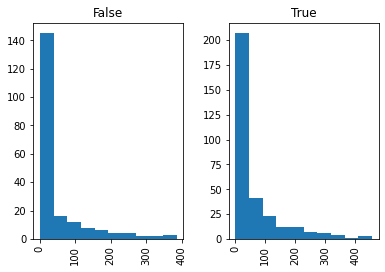

In [7]:
b4Trial_dict = {}
for ID in IDs:
    trial_start = pd.to_datetime(SubscriptionHistory[(SubscriptionHistory['user']==ID)&(SubscriptionHistory['event']=='subscription-free-trial')]['eventDate'].values)
    create_date = pd.to_datetime(CommunityMember[(CommunityMember['user']==ID)]['createdAt'].values)
    b4Trial_dict[ID] = (trial_start-create_date).days.values[0]
    
b4Trial_df = pd.DataFrame(list(b4Trial_dict.items()), columns = ['user', 'days_create2Trial']).set_index(['user'])
b4Trial_df['Converted'] = bool(True)
b4Trial_df.loc[list(nonconverted), 'Converted'] =  bool(False)

# print ('Trial users whose subscribe before creation date')
# print (b4Trial_df[b4Trial_df.days_create2Trial < 0])

b4Trial_filter = b4Trial_df[(b4Trial_df.days_create2Trial > 0)]
print ('Users that created an account before trial')
print (b4Trial_filter.groupby(['Converted']).agg(['count']), '\n')

print ('The number of days before trial of these users \n X-axis = number of days before trials \n y-axis = freq')
print (b4Trial_filter.days_create2Trial.hist(by=b4Trial_filter.Converted))

## 5. Feature engineering

In [8]:
# During trial: freq, cons
DFs = ActivityComplete, SessionCompleted, LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed
trial_activity = feature_duration(DFs, IDs, SubscriptionHistory)

original shape (33024, 3), after filtering (2540, 3)
original shape (138615, 3), after filtering (8709, 3)
original shape (224454, 3), after filtering (10648, 3)
original shape (8248479, 3), after filtering (83736, 3)
original shape (649540, 2), after filtering (18251, 2)
original shape (1820641, 3), after filtering (96517, 3)


In [9]:
# During first 2 days of trial: freq
DFs = trial_activity['ActivityComplete']['filter'], trial_activity['SessionCompleted']['filter'], \
trial_activity['LibrarySelectedTab']['filter'], trial_activity['ScreenViewed']['filter'], \
trial_activity['AppForeground']['filter'], trial_activity['SessionViewed']['filter']
trial2_activity = feature_duration(DFs, IDs, SubscriptionHistory, duration = 3, consecutive = False)

original shape (2540, 3), after filtering (642, 3)
original shape (8709, 3), after filtering (6346, 3)
original shape (10648, 3), after filtering (8278, 3)
original shape (83736, 3), after filtering (53653, 3)
original shape (18251, 2), after filtering (11961, 2)
original shape (96517, 3), after filtering (55870, 3)


In [21]:
# Before trial: freq, daily ave, norm
DFs = ActivityComplete, SessionCompleted, LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed
b4_activity = feature_duration(DFs, IDs, SubscriptionHistory, add = False, consecutive = False, cal_ave = True, dayDF = b4Trial_filter)

original shape (33024, 3), after filtering (11, 3)
original shape (138615, 3), after filtering (674, 3)
original shape (224454, 3), after filtering (1135, 3)
original shape (8248479, 3), after filtering (9567, 3)
original shape (649540, 2), after filtering (1385, 2)
original shape (1820641, 3), after filtering (5109, 3)


In [22]:
# 7 days before and 7 days during trial: cons

DFs = pd.concat([trial_activity['ActivityComplete']['filter'], b4_activity['ActivityComplete']['filter']]), \
pd.concat([trial_activity['SessionCompleted']['filter'], b4_activity['SessionCompleted']['filter']]), \
pd.concat([trial_activity['LibrarySelectedTab']['filter'], b4_activity['LibrarySelectedTab']['filter']]), \
pd.concat([trial_activity['ScreenViewed']['filter'], b4_activity['ScreenViewed']['filter']]), \
pd.concat([trial_activity['AppForeground']['filter'], b4_activity['AppForeground']['filter']]), \
pd.concat([trial_activity['SessionViewed']['filter'], b4_activity['SessionViewed']['filter']])

b4_duringTrial_activity = feature_duration(DFs, IDs, SubscriptionHistory, filter = False, freq = False)

## 6. Feature dataframe
Column 'Converted': True = converted, False = nonconverted 

In [470]:
# Converted/Churned Trial Users - Select users that do not have ambiguous days before trial
feature_df = b4Trial_df[(b4Trial_df.days_create2Trial >= 0)]
# m = b4Trial_df[(b4Trial_df.days_create2Trial >= 0)]
# IDs_loaded = []
# for line in open('../results/IDs.txt'):
#     line = line.strip('\n')
#     IDs_loaded.append(line)
# feature_df = pd.DataFrame(index = IDs_loaded, columns=['Converted'])
# feature_df.index.name = 'user'
# feature_df['Converted'] = bool(True)
# feature_df.loc[list(nonconverted), 'Converted'] =  bool(False)
# feature_df['days_create2Trial'] = m['days_create2Trial']

In [471]:
# Features: Goal & Experience
CommunityMember_join = CommunityMember[['user','goal', 'exp']].set_index('user')
feature_df = feature_df.join(CommunityMember_join)
feature_df = feature_df[feature_df.goal.notnull()]
feature_df = feature_df[feature_df.exp.notnull()]
# one hot encoding
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['goal'], prefix='goal')],axis=1)
feature_df.drop(['goal'],axis=1, inplace=True)
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['exp'], prefix='exp')],axis=1)
feature_df.drop(['exp'],axis=1, inplace=True)

In [472]:
# Append app activity features
def append_feature_df (feature, pre_column, renamed_column, feature_df):
    feature_renamed = feature.rename(columns={pre_column:renamed_column})
    feature_df_new = feature_df.join(feature_renamed[renamed_column])
    return feature_df_new
    
def iterate_feature_type (df, df_name, feature_df, feature_types= [('norm', 'normed_daily_ave'), \
('cons', 'number_consecutive_day'), ('ave', 'daily_ave'), ('freq', 'count')]):
    for activity_name in df:
        for metrics, metric_name in feature_types:
            try:
                feature = df[activity_name][metrics]
                new_name = df_name+'_'+ activity_name+'_'+metrics
                feature_df = append_feature_df (feature, metric_name, new_name, feature_df)
            except:
                pass
    return feature_df
            
feature_df_new = iterate_feature_type (b4_activity, 'b4Trial', feature_df)
feature_df_new = iterate_feature_type (trial_activity, '7dTrial', feature_df_new)
feature_df_new = iterate_feature_type (trial2_activity, '2dTrial', feature_df_new)
feature_df_new = iterate_feature_type (b4_duringTrial_activity, 'b4_duringTrial', feature_df_new)

(1551, 27)
(1551, 39)
(1551, 45)
(1551, 51)


In [473]:
feature_df_new = feature_df_new.fillna(0)
feature_df_new.shape

(1551, 51)

## 7. Predictive models for converted/churned trial users

In [658]:
# X and y, train and test sets
X = feature_df_new.loc[:,feature_df_new.columns!='Converted'][sel_drop]
y = feature_df_new['Converted']
X = X.astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [651]:
# Grid search for hyperparameters
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5) #stratified CV, CV k-fold = 10, one for all
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 100}

F1 scores: 0.6738999291315986
Confusion Matrix
[[140  25]
 [ 73  73]]


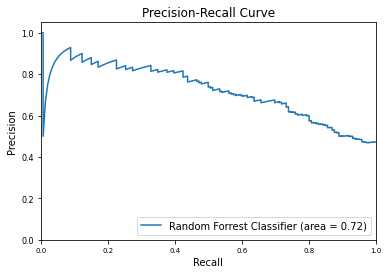

In [653]:
# A model with the best performing hyperparameters
rf=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=8, criterion='entropy', oob_score = True)
selector = rf.fit(X_train, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Test Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_test, y_test)))

# AUCs
plot_AUC(selector, X_test, y_test)

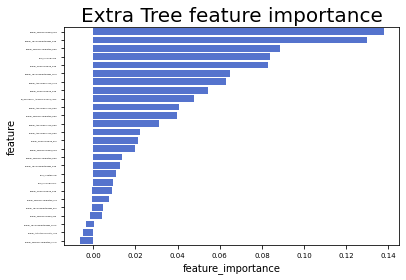

In [587]:
# Feature importance
perm = PermutationImportance(selector, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
var_imp_plot4(perm_imp_eli5, 'Permutation feature importance (eli5)')

base_imp = imp_df(X_train.columns, rf.feature_importances_)
var_imp_plot4(base_imp, 'Default feature importance (sklearn)')

drop_imp = drop_col_feat_imp(selector, X_train, y_train)
var_imp_plot(drop_imp, 'Drop Column feature importance')

extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2) 
extra_tree_forest.fit(X_train, y_train) 
feature_importance = extra_tree_forest.feature_importances_ 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0) 
df_fi = pd.DataFrame(list(zip(X.columns, feature_importance_normalized)), columns=['feature','feature_importance'])
df_fi = df_fi.sort_values(by=['feature_importance'], ascending = False)
var_imp_plot(df_fi, 'Extra Tree feature importance')

F1 scores: 0.7672188317349607
Confusion Matrix
[[844  20]
 [247 440]]


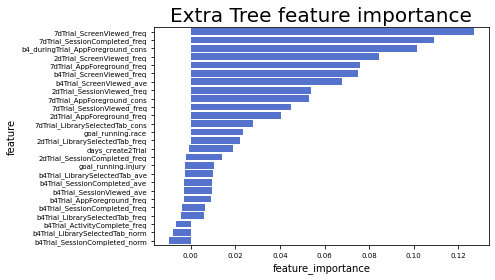

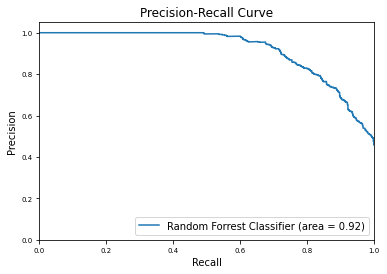

In [610]:
# retrain the model on the whole dataset
selector = rf.fit(X, y)
plot_AUC(selector, X, y)

perm = PermutationImportance(selector, cv = None, refit = False, n_iter = 50).fit(X, y)
perm_imp_eli5 = imp_df(X.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

base_imp = imp_df(X.columns, rf.feature_importances_)
var_imp_plot(base_imp, 'Default feature importance (sklearn)')

drop_imp = drop_col_feat_imp(selector, X, y)
var_imp_plot(drop_imp, 'Drop Column feature importance 3')

extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2) 
extra_tree_forest.fit(X, y) 
feature_importance = extra_tree_forest.feature_importances_ 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0) 
df_fi = pd.DataFrame(list(zip(X.columns, feature_importance_normalized)), columns=['feature','feature_importance'])
df_fi = df_fi.sort_values(by=['feature_importance'], ascending = False)
var_imp_plot(df_fi, 'Extra Tree feature importance')

In [109]:
'''
# decision path
estimator = rf.estimators_[2]
plot_decisionPath(estimator, X, class_name = ['Churned', 'Converted'])
'''

In [559]:
'''
# select what features to keep based on feature importance
sel_extraTree = list(df_fi[df_fi.feature_importance > 0].feature)
sel_perm = list(perm_imp_eli5[perm_imp_eli5.feature_importance > 0].feature) 
sel_drop = list(drop_imp[drop_imp.feature_importance > 0].feature)
'''

In [638]:
'''
# recursive feature elimination 
rfe_dict = {}
for i in range(1,50):
    selector = RFE(rf, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, y_train)
    probs = selector.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rfe_dict[i] = roc_auc
lists = sorted(rfe_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
selector = RFE(rf, n_features_to_select=6, step=1)
selector = selector.fit(X_train, y_train)
selected_features = X.columns[selector.support_]

plt.plot(x,y)
plt.xlabel('Number of features')
plt.ylabel('AUROC')
plt.savefig('../results/RFE_AUROC.png', dpi=800, transparent = True)
'''

"\n# recursive feature elimination \nrfe_dict = {}\nfor i in range(1,50):\n    selector = RFE(rf, n_features_to_select=i, step=1)\n    selector = selector.fit(X_train, y_train)\n    probs = selector.predict_proba(X_test)\n    preds = probs[:,1]\n    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)\n    roc_auc = metrics.auc(fpr, tpr)\n    rfe_dict[i] = roc_auc\nlists = sorted(rfe_dict.items()) # sorted by key, return a list of tuples\nx, y = zip(*lists) # unpack a list of pairs into two tuples\nselector = RFE(rf, n_features_to_select=6, step=1)\nselector = selector.fit(X_train, y_train)\nselected_features = X.columns[selector.support_]\n\nplt.plot(x,y)\nplt.xlabel('Number of features')\nplt.ylabel('AUROC')\nplt.savefig('../results/RFE_AUROC.png', dpi=800, transparent = True)\n"

In [663]:
'''
# save datafranes
drop_imp.to_csv('../results/drop_imp_whole')
X.to_csv('../results/X')
y.to_csv('../results/y')
feature_df_new.to_csv('../results/feature_df_new')
'''

## 8. Model comparisons

In [672]:
# X and y, train and test sets
X = feature_df_new.loc[:,feature_df_new.columns!='Converted'][sel_drop]
y = feature_df_new['Converted']
X = X.astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [694]:
# Grid search for hyperparameters
# Random forest
rfc=RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
y_pred_rf = CV_rfc.predict(X_test)

# Logistic regression
clf = LogisticRegression(max_iter=10000)
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_train, y_train)
y_pred_logistic = grid_clf_acc.predict(X_test)

# XG Boost
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
y_pred_xgboost = gsearch4.predict(X_test)

print('Random Forest\n')
print_metrics(y_test, y_pred_rf)
print ('Logictic Regression\n')
print_metrics(y_test, y_pred_logistic)
print ('XG Boost\n')
print_metrics(y_test, y_pred_xgboost)

/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


XG Boost

Accuracy Score : 0.662379421221865
Precision Score : 0.6541353383458647
Recall Score : 0.5958904109589042
F1 Score : 0.6236559139784947
Confusion Matrix : 
[[119  46]
 [ 59  87]]


In [699]:
grid_clf_acc.best_params_

{'C': 0.01, 'penalty': 'l2'}

F1 scores: 0.6837994278265866
Confusion Matrix
[[150  15]
 [ 78  68]]


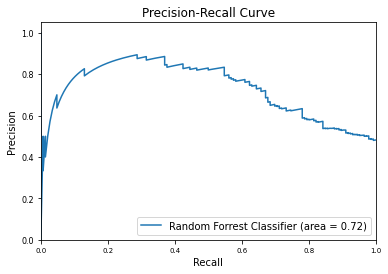

In [709]:
lg = LogisticRegression(max_iter=10000, C = 0.01, penalty='l2')
selector = lg.fit(X_train, y_train)
plot_AUC(selector, X_test, y_test)

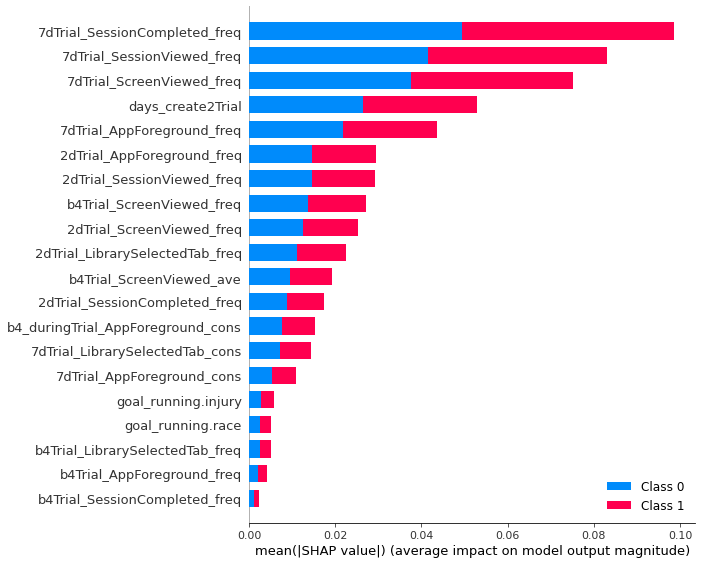

In [740]:
rf=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=8, criterion='entropy', oob_score = True)
selector = rf.fit(X_train, y_train)
explainer = shap.TreeExplainer(selector)
shap_values = explainer.shap_values(X)
f = plt.figure()
shap.initjs()
shap.summary_plot(shap_values, X)
f.savefig('../results/shap.png', bbox_inches='tight', dpi=600)

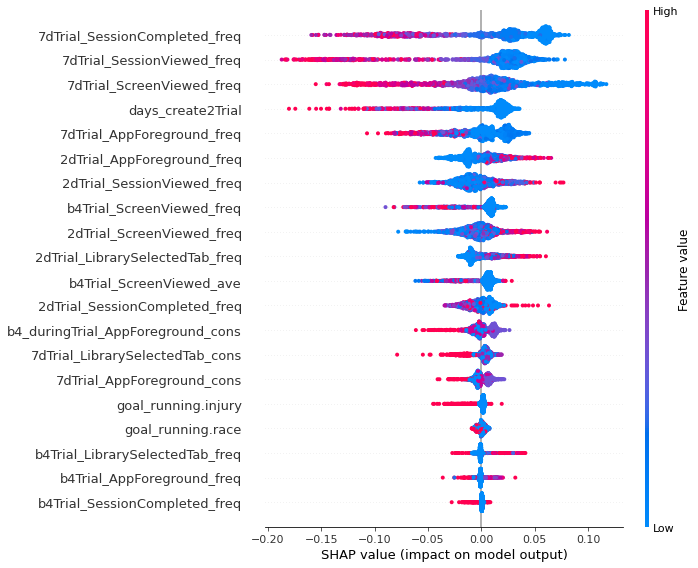

In [742]:
shap.summary_plot(shap_values[0], X)

In [734]:
instance_to_explain = 3
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_to_explain], X_test.iloc[instance_to_explain])